<a href="https://colab.research.google.com/github/vishn96/Vehicle-Detection-Model/blob/main/Vehicle_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting the current working directory
import os; os.chdir('/content/drive/My Drive/PGP/Dynamic Bounding Box')

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set random_state
random_state = 2020

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tensorflow.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 1.1.5
Numpy version: 1.19.5
Scikit-learn version: 0.22.2.post1
Tensorflow version: 2.4.1
CV version: 4.1.2


In [ ]:
!ls

Video


In [ ]:
!ls

Video


In [ ]:
import sys
import argparse

import cv2
print(cv2.__version__)


4.1.2


In [ ]:
import cv2
import numpy as np
import os

# set video file path of input video with name and extension
vid = cv2.VideoCapture('/content/drive/My Drive/PGP/Dynamic Bounding Box/Video/video1.mp4')


if not os.path.exists('images'):
    os.makedirs('images')

#for frame identity
index = 0
while(True):
    # Extract images
    ret, frame = vid.read()
    # end of frames
    if not ret: 
        break
    # Saves images
    name = './images/frame' + str(index) + '.png'
    print ('Creating...' + name)
    cv2.imwrite(name, frame)

    # next frame
    index += 1

Creating..../images/frame0.png
Creating..../images/frame1.png
Creating..../images/frame2.png
Creating..../images/frame3.png
Creating..../images/frame4.png
Creating..../images/frame5.png
Creating..../images/frame6.png
Creating..../images/frame7.png
Creating..../images/frame8.png
Creating..../images/frame9.png
Creating..../images/frame10.png
Creating..../images/frame11.png
Creating..../images/frame12.png
Creating..../images/frame13.png
Creating..../images/frame14.png
Creating..../images/frame15.png
Creating..../images/frame16.png
Creating..../images/frame17.png
Creating..../images/frame18.png
Creating..../images/frame19.png
Creating..../images/frame20.png
Creating..../images/frame21.png
Creating..../images/frame22.png
Creating..../images/frame23.png
Creating..../images/frame24.png
Creating..../images/frame25.png
Creating..../images/frame26.png
Creating..../images/frame27.png
Creating..../images/frame28.png
Creating..../images/frame29.png
Creating..../images/frame30.png
Creating..../image

In [ ]:
# get file names of the frames
col_frames = os.listdir("/content/drive/My Drive/PGP/Dynamic Bounding Box/images/")

# sort file names
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# empty list to store the frames
col_images=[]

for i in col_frames:
    # read the frames
    img = cv2.imread("/content/drive/My Drive/PGP/Dynamic Bounding Box/images/"+i)
    # append the frames to the list
    col_images.append(img)

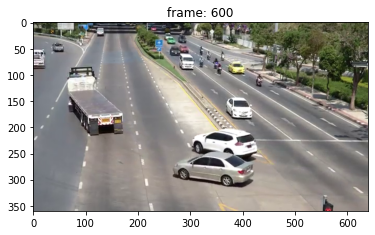

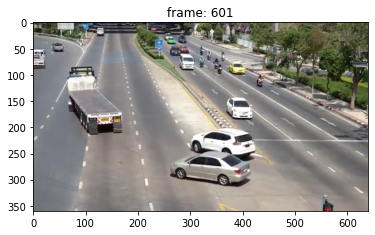

In [ ]:
# plot 600th frame
i = 600

for frame in [i, i+1]:
    plt.imshow(cv2.cvtColor(col_images[frame], cv2.COLOR_BGR2RGB))
    plt.title("frame: "+str(frame))
    plt.show()

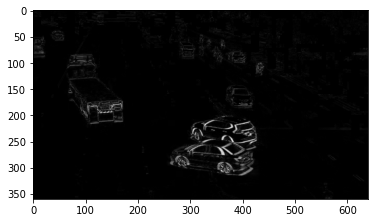

In [ ]:
# convert the frames to grayscale
grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)

# plot the image after frame differencing
plt.imshow(cv2.absdiff(grayB, grayA), cmap = 'gray')
plt.show()

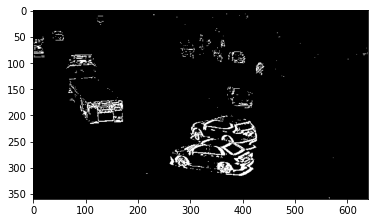

In [ ]:
diff_image = cv2.absdiff(grayB, grayA)

# perform image thresholding
ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)

# plot image after thresholding
plt.imshow(thresh, cmap = 'gray')
plt.show()

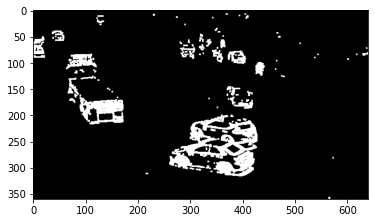

In [ ]:
# apply image dilation
kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(thresh,kernel,iterations = 1)

# plot dilated image
plt.imshow(dilated, cmap = 'gray')
plt.show()

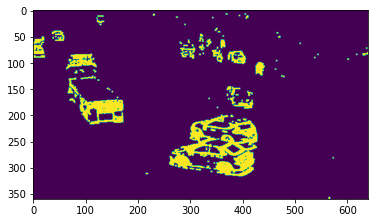

In [ ]:
# plot vehicle detection zone
plt.imshow(dilated)
cv2.line(dilated, (0, 80),(256,80),(100, 0, 0))
plt.show()

In [ ]:
# find contours
contours, hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

In [ ]:
valid_cntrs = []

for i,cntr in enumerate(contours):
    x,y,w,h = cv2.boundingRect(cntr)
    if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
        valid_cntrs.append(cntr)

# count of discovered contours        
len(valid_cntrs)

14

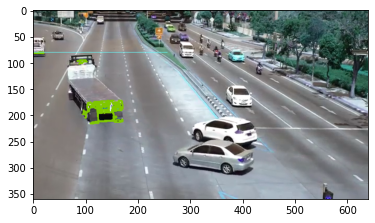

In [ ]:
dmy = col_images[600].copy()

cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
cv2.line(dmy, (0, 80),(256,80),(100, 255, 255))
plt.imshow(dmy)
plt.show()

In [ ]:
# kernel for image dilation
kernel = np.ones((4,4),np.uint8)

# font style
font = cv2.FONT_HERSHEY_SIMPLEX

# directory to save the ouput frames
pathIn = "/content/drive/My Drive/PGP/Dynamic Bounding Box/output/"

for i in range(len(col_images)-1):
    
    # frame differencing
    grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)
    diff_image = cv2.absdiff(grayB, grayA)
    
    # image thresholding
    ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)
    
    # image dilation
    dilated = cv2.dilate(thresh,kernel,iterations = 1)
    
    # find contours
    contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    
    # shortlist contours appearing in the detection zone
    valid_cntrs = []
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
            if (y >= 90) & (cv2.contourArea(cntr) < 40):
                break
            valid_cntrs.append(cntr)
            
    # add contours to original frames
    dmy = col_images[i].copy()
    cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
    cv2.rectangle(dmy, (x,y),(x+w,y+h),(0,255,0),2)
    cv2.putText(dmy, "vehicles detected: " + str(len(valid_cntrs)), (55, 15), font, 0.6, (0, 180, 0), 2)
    cv2.line(dmy, (0, 80),(256,80),(100, 255, 255))
    cv2.imwrite(pathIn+str(i)+'.png',dmy) 

In [ ]:
# specify video name
pathOut = '/content/drive/My Drive/PGP/Dynamic Bounding Box/vehicle_detection_v3.mp4'

# specify frames per second
fps = 14.0

In [ ]:
import cv2
import os

image_folder = '/content/drive/My Drive/PGP/Dynamic Bounding Box'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()